# Comparing Clustering Algorithms on the Digits Dataset

Our goal is to get a feel as to how various clustering algorithms perform at a relatively simple clustering task. For data we will be using the digits dataset of handwritten digits encoded as 64 long vectors representing 8x8 pixel intensity drawings.

First up we'll load up all the modules we'll need.

In [3]:
import sklearn.datasets
import sklearn.cluster
import sklearn.manifold
import hdbscan
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

Now we can load up the digits dataset directly from sklearn (which kindly provides a number of simple test datasets)

In [2]:
digits_data = sklearn.datasets.load_digits()
print(digits_data.DESCR)

 Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is 

Seeing how well the various clustering algorithms worked is a problem; we could use various clustering goodness measures but they often involve assumptions about the data, or the clustering, or both. To get a real intuition for what is going on the best thing to do is visualize the data and *see* what is going on. We'll discuss this more as we go on. To see what is going on we need to be able to visualize the digits dataset; for that we need fewer dimensions. A good way of doign this is the t-SNE dimension reduction technique, conveniently available in sklearn. We can use that to find a two dimensional projection of the data that we can then plot.

In [7]:
projection = sklearn.manifold.t_sne.TSNE()
projection.fit(digits_data.data)

Now that we have a projection we can plot the data, colored by target labels (i.e. which digit the vector represents).

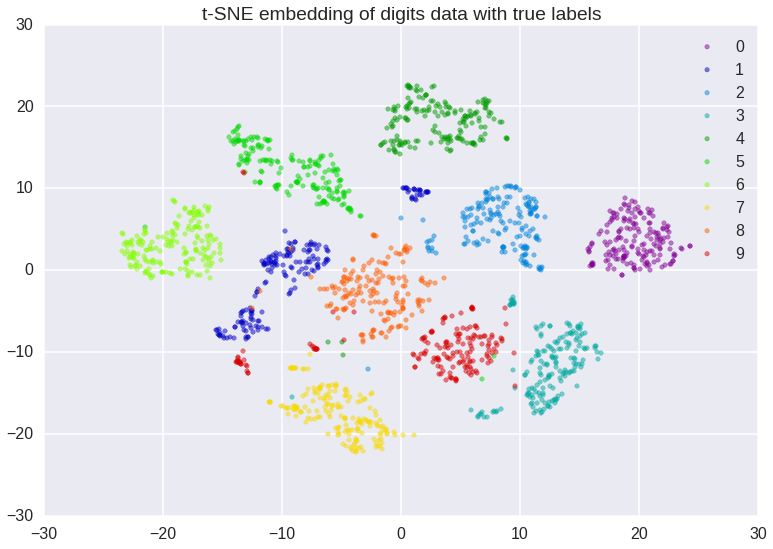

In [8]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in digits_data.target_names:
    plt.scatter(projection.embedding_.T[0][digits_data.target == digit], 
                projection.embedding_.T[1][digits_data.target == digit], 
                color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with true labels')
plt.legend()

Now we know what a perfect clustering looks like, let's move on to trying out various clustering algorithms and see how they look.

## DBSCAN

We'll start with just the default params -- a big part of our goal in clustering for data exploration is not having to know a great deal about our data before we can pull out meaningful informaton via clustering.

In [64]:
%%time
dbscan_labels = sklearn.cluster.DBSCAN().fit_predict(digits_data.data)

CPU times: user 536 ms, sys: 24 ms, total: 560 ms
Wall time: 1.6 s


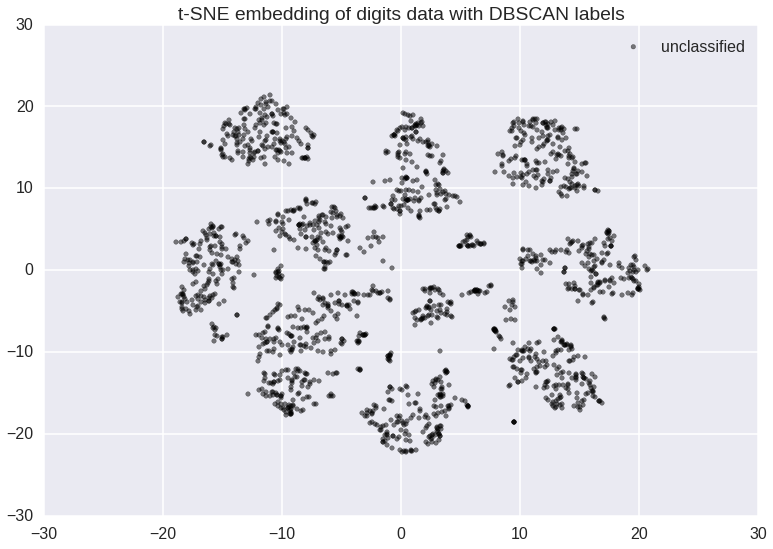

In [65]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in set(dbscan_labels):
    if digit == -1:
        plt.scatter(projection.embedding_.T[0][dbscan_labels == digit], 
                    projection.embedding_.T[1][dbscan_labels == digit], 
                    color='black', alpha=0.5, label='unclassified')
    else:
        plt.scatter(projection.embedding_.T[0][dbscan_labels == digit], 
                    projection.embedding_.T[1][dbscan_labels == digit], 
                    color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with DBSCAN labels')
plt.legend()

Well that was underwhelming. To be fair DBSCAN is very sensitive to distance scales, so this isn't all that surprising. We can try and adjust our parameters and get a more sensible answer. To do that we need to get some idea of the distance scale we are working with. A quick and dirty histogram of the flattened distance matrix will give us the ability take a quick guess.

In [9]:
from sklearn.metrics import pairwise_distances

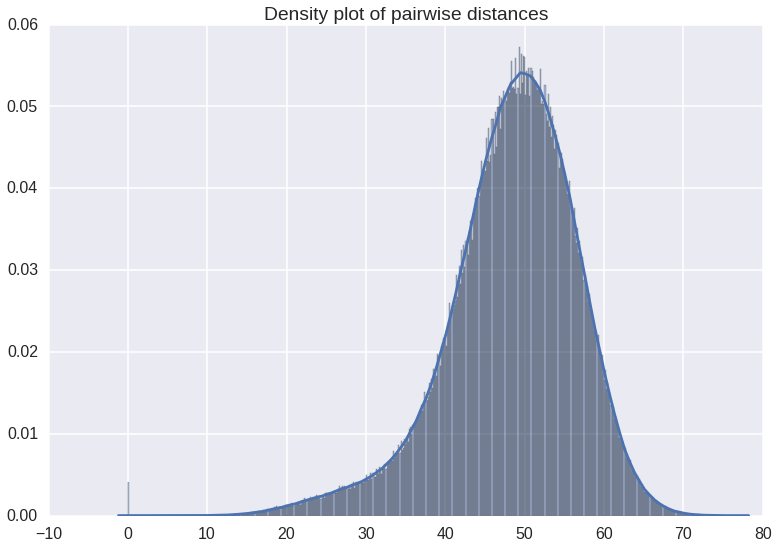

In [67]:
sns.distplot(pairwise_distances(digits_data.data).flatten())
plt.title("Density plot of pairwise distances")

We want to select off the left tail, so by rough eyeball, let's say a little above 20 as a good value for epsilon.

In [68]:
%%time
dbscan_labels = sklearn.cluster.DBSCAN(eps=22.5).fit_predict(digits_data.data)

CPU times: user 5.5 s, sys: 32 ms, total: 5.53 s
Wall time: 7.85 s


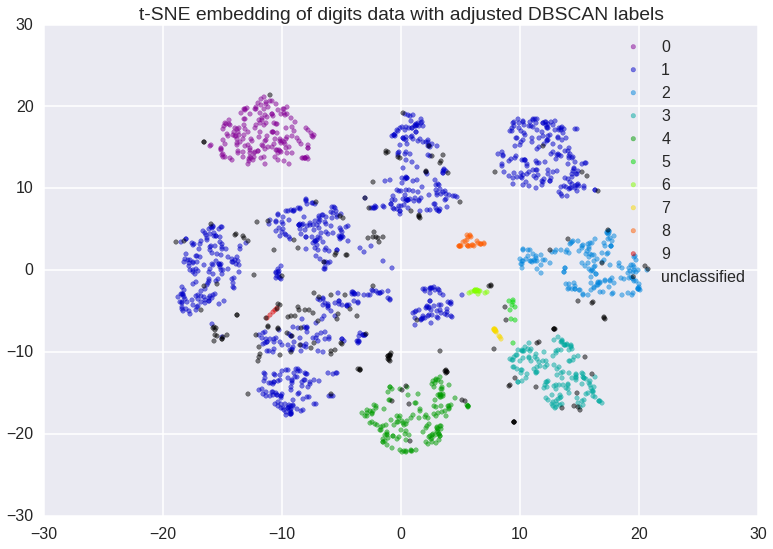

In [69]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in set(dbscan_labels):
    if digit == -1:
        plt.scatter(projection.embedding_.T[0][dbscan_labels == digit], 
                    projection.embedding_.T[1][dbscan_labels == digit], 
                    color='black', alpha=0.5, label='unclassified')
    else:
        plt.scatter(projection.embedding_.T[0][dbscan_labels == digit], 
                    projection.embedding_.T[1][dbscan_labels == digit], 
                    color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with adjusted DBSCAN labels')
plt.legend()

Well that is certainly better than our default params, but still remarkably underwhelming. A little more playing with epsilon values will convince you that we won't get too much improvement, and that it is very hard to select epsilon values as the resulting clustering is surprsingly unstable. If we were to believe thiswe would get a very strange idea about what our data looked like. If we were to vary the epsilon we would rapidly be very confused indeed.

## K-Means

To keep things even we will again begin with default params and see how things go.

In [70]:
%%time
kmeans_labels = sklearn.cluster.KMeans().fit_predict(digits_data.data)

CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 2.35 s


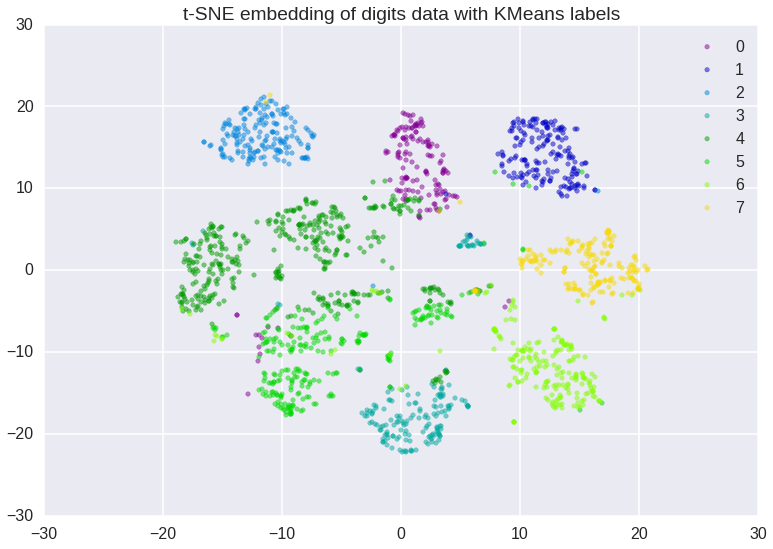

In [71]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in set(kmeans_labels):
    plt.scatter(projection.embedding_.T[0][kmeans_labels == digit], 
                projection.embedding_.T[1][kmeans_labels == digit], 
                color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with KMeans labels')
plt.legend()

This is fairly similar to the results of a slightly tuned DBSCAN. We are helped, here, by the fact that K-means chose seven clusters as the default. We can, of course, tune K-means parameters, but here we are using knowledge (that there are 10 clusters/classes) that happen to have for this dataset, but in general won't have. We could do multiple clusterings with varying K-values and, using a suitable clustering measure, try to pick a good value. Let's go with the best possible outcome and assume 10 clusters.

In [5]:
%%time
kmeans_labels = sklearn.cluster.KMeans(10).fit_predict(digits_data.data)

CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 3.15 s


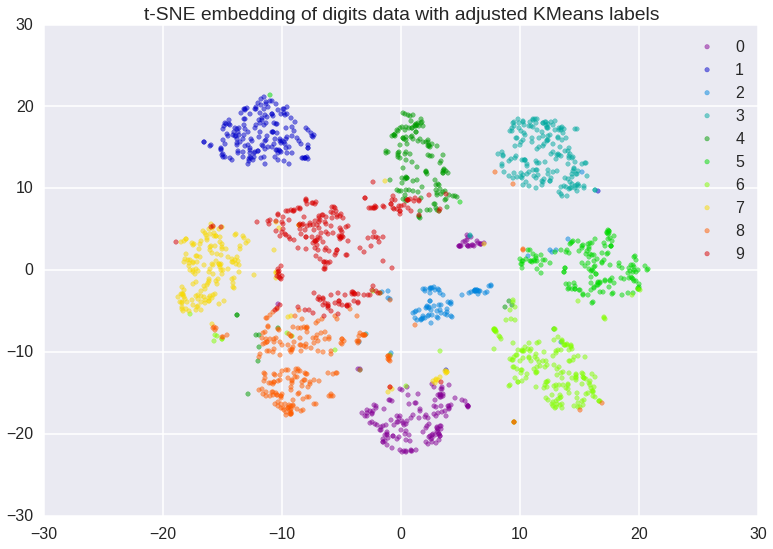

In [73]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in set(kmeans_labels):
    plt.scatter(projection.embedding_.T[0][kmeans_labels == digit], 
                projection.embedding_.T[1][kmeans_labels == digit], 
                color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with adjusted KMeans labels')
plt.legend()

A good result, but it helped to have a correct parmaeter value. Even with this we have a large number of points misclassified, which gives the clusters rather a different shape and distribution, which can be deceptive and confuse intuition. We're better off then DBSCAN in this case (partly because we had a priori knowledge of the 'true' parameter values), but the results can still lead us astray if we believe these are actual clusters as opposed to a 'good' partitioning of the data.

In [4]:
pd.Series(digits_data.target).value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

In [6]:
pd.Series(kmeans_labels).value_counts()

7    254
1    219
5    206
4    182
0    179
3    177
8    175
2    167
6    147
9     91
dtype: int64

## Affinity Propagation

The strength of affinity propagation is that it supports the use of similarities rather than a strict metric. That means we are using it in a case where we aren't playing to it's strengths; still we can look at what we get with default parameters.

In [9]:
%%time
ap_labels = sklearn.cluster.AffinityPropagation().fit_predict(digits_data.data)

CPU times: user 27.6 s, sys: 468 ms, total: 28 s
Wall time: 31.3 s


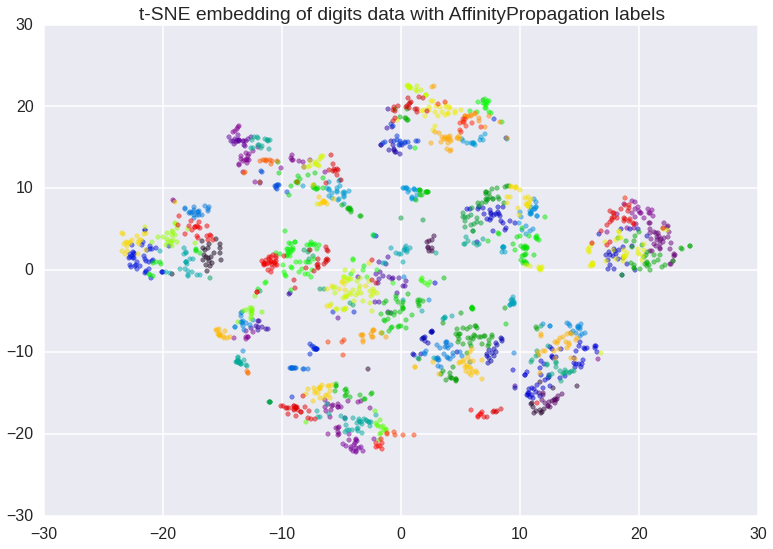

In [10]:
palette = sns.palettes.color_palette('spectral', 110)
for digit in set(ap_labels):
    plt.scatter(projection.embedding_.T[0][ap_labels == digit], 
                projection.embedding_.T[1][ap_labels == digit], 
                color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with AffinityPropagation labels')
#plt.legend() There are over 100 clusters so we can really provide a useful legend

This is a very random scattering of data. Since affinity propagation works by selecting cluster exemplars and then effectively running one round of k-medians on those exemplars to assign points to clusters this looks roughly like what we might expect to see if we randomly chose some very large number of exemplars (say 100) and then ran one round of k-medians. That is to say, this is a very underwhelming clustering. We can work to improve things by playing with parameters. For affinity propagation this means the preference vector which we can try to decrease (it defaults to the median of all pairwise similarities). In practice I have no good way to estimate what this parameter should be, so repeated attempts playing with the parameter until I at least got a small number of clusters was how I arrived at the preference value below.

In [13]:
%%time
ap_labels = sklearn.cluster.AffinityPropagation(preference=-50000.0).fit_predict(digits_data.data)

CPU times: user 2min 24s, sys: 1.79 s, total: 2min 26s
Wall time: 2min 59s


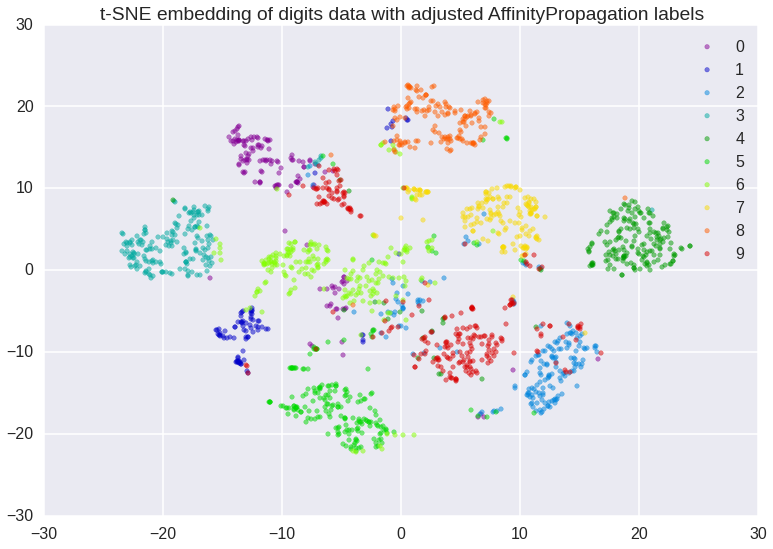

In [12]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in set(ap_labels):
    plt.scatter(projection.embedding_.T[0][ap_labels == digit], 
                projection.embedding_.T[1][ap_labels == digit], 
                color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with adjusted AffinityPropagation labels')
plt.legend()

This looks superficially better, but in practice there is a variety of misclassification, and clsuter size distributions are quite dissimilar from reality. Once again our intuitions are going to be lead astray.

In [14]:
pd.Series(ap_labels).value_counts()

9    246
6    228
5    206
4    199
2    189
3    180
7    167
8    157
0    140
1     85
dtype: int64

In [15]:
%%time
agg_labels = sklearn.cluster.AgglomerativeClustering().fit_predict(digits_data.data)

CPU times: user 18.8 s, sys: 116 ms, total: 18.9 s
Wall time: 20 s


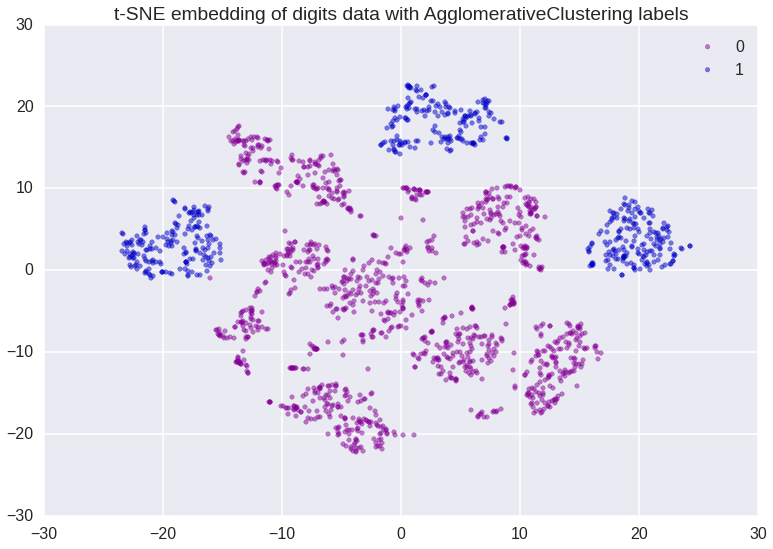

In [16]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in set(agg_labels):
    plt.scatter(projection.embedding_.T[0][agg_labels == digit], 
                projection.embedding_.T[1][agg_labels == digit], 
                color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with AgglomerativeClustering labels')
plt.legend()

In [17]:
%%time
agg_labels = sklearn.cluster.AgglomerativeClustering(10).fit_predict(digits_data.data)

CPU times: user 19.4 s, sys: 180 ms, total: 19.6 s
Wall time: 23.1 s


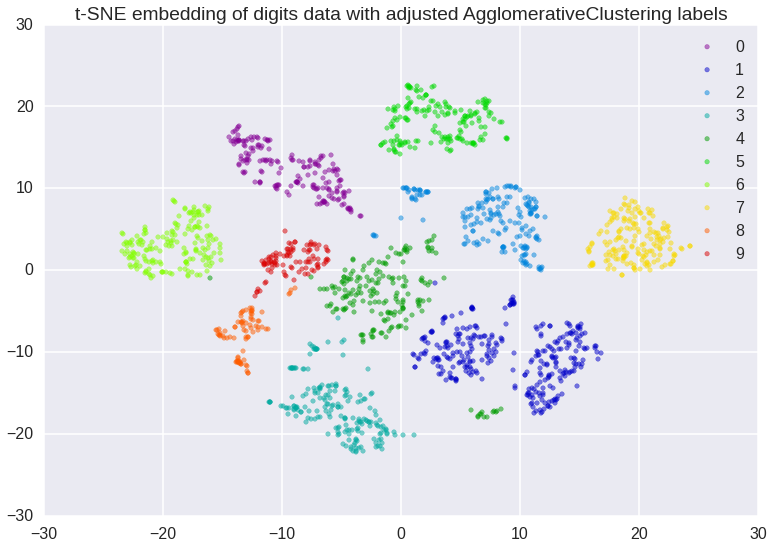

In [18]:
palette = sns.palettes.color_palette('spectral', 10)
for digit in set(agg_labels):
    plt.scatter(projection.embedding_.T[0][agg_labels == digit], 
                projection.embedding_.T[1][agg_labels == digit], 
                color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with adjusted AgglomerativeClustering labels')
plt.legend()

In [25]:
%%time
hdbscan_labels = hdbscan.HDBSCAN().fit_predict(digits_data.data)

CPU times: user 1.76 s, sys: 120 ms, total: 1.88 s
Wall time: 1.99 s


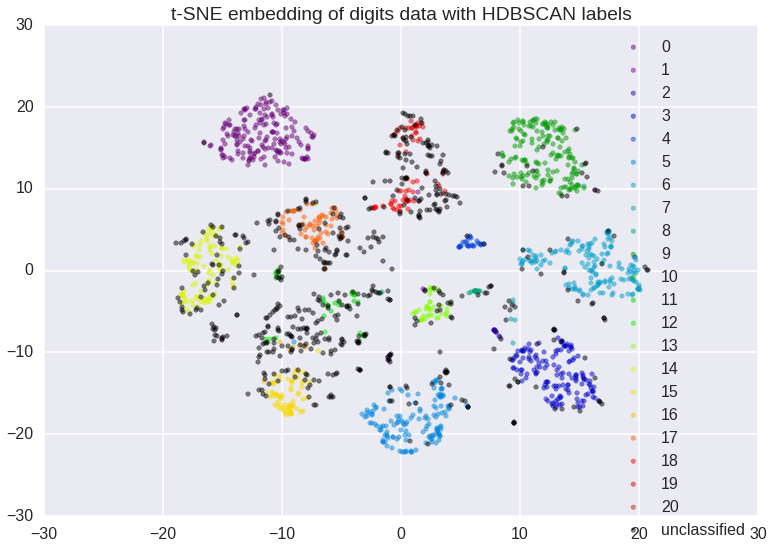

In [37]:
palette = sns.palettes.color_palette('spectral', 21)
for digit in set(map(int,hdbscan_labels)):
    if digit == -1:
        plt.scatter(projection.embedding_.T[0][hdbscan_labels == digit], 
                    projection.embedding_.T[1][hdbscan_labels == digit], 
                    color='black', alpha=0.5, label='unclassified')
    else:
        plt.scatter(projection.embedding_.T[0][hdbscan_labels == digit], 
                    projection.embedding_.T[1][hdbscan_labels == digit], 
                    color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with HDBSCAN labels')
plt.legend()

In [59]:
%%time
hdbscan_labels = hdbscan.HDBSCAN(min_samples=8, min_cluster_size=20).fit_predict(digits_data.data)

CPU times: user 1.74 s, sys: 108 ms, total: 1.85 s
Wall time: 1.9 s


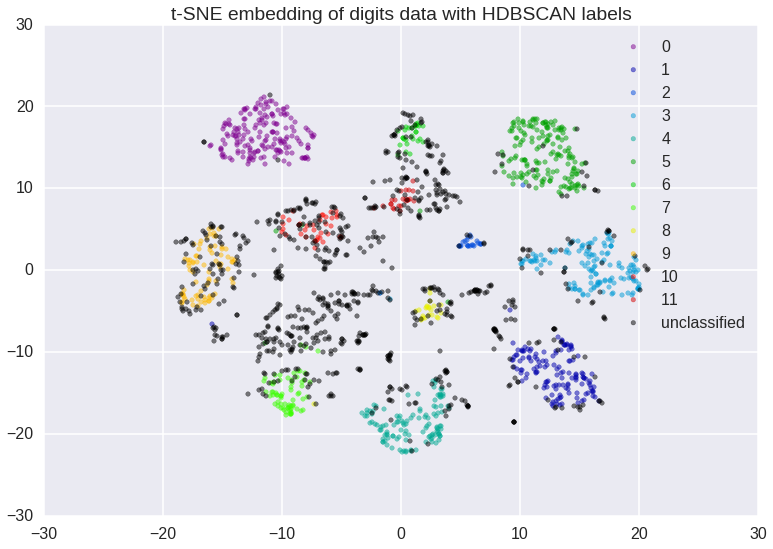

In [60]:
palette = sns.palettes.color_palette('spectral', 12)
for digit in set(map(int,hdbscan_labels)):
    if digit == -1:
        plt.scatter(projection.embedding_.T[0][hdbscan_labels == digit], 
                    projection.embedding_.T[1][hdbscan_labels == digit], 
                    color='black', alpha=0.5, label='unclassified')
    else:
        plt.scatter(projection.embedding_.T[0][hdbscan_labels == digit], 
                    projection.embedding_.T[1][hdbscan_labels == digit], 
                    color=palette[digit], alpha=0.5, label=str(digit))
plt.title('t-SNE embedding of digits data with HDBSCAN labels')
plt.legend()